# NinjaCap-wholeHeadHD-probe registration to Colin27
This example jupyter notebook shows how to align the optodes of the NinjaCap-wholeHeadHD to the Colin27 head model.
Thorough coregistration is the foundation of every data analysis using head models. 

Currently, `cedaĺion` offers a simple registration method, which finds an affine transformation (scaling, rotating, translating) that matches the landmark positions of the head model and their digitized counterparts (probe data). Afterward, optodes are snapped to the nearest vertex on the scalp.

In [1]:
import pyvista as pv
#pv.set_jupyter_backend('html')
pv.set_jupyter_backend('static')
#pv.OFF_SCREEN=True

In [2]:
import os, numpy as np, xarray as xr

import cedalion
import cedalion.io as cio
import cedalion.datasets
import cedalion.imagereco.forward_model as fw
import cedalion.geometry.registration as cgeoreg
import cedalion.geometry.landmarks as cgeolm
import cedalion.plots as cp

## Load segmented MRI scan

For this example use a segmentation of the Colin27 average brain.

In [3]:
SEG_DATADIR, mask_files, landmarks_file = cedalion.datasets.get_colin27_segmentation()
masks, t_ijk2ras = cedalion.io.read_segmentation_masks(SEG_DATADIR, mask_files)

Construct Colin27 headmodel from segmentation masks

In [4]:
colin = fw.TwoSurfaceHeadModel.from_segmentation(
    segmentation_dir=SEG_DATADIR,
    mask_files = mask_files,
    landmarks_ras_file=landmarks_file,
    smoothing=0.5,
    fill_holes=True,
)
colin.scalp.units = cedalion.units.mm
colin.brain.units = cedalion.units.mm

## Compute EEG's 10-10 system landmarks of Colin27 for optode coregistration

/usr/local/lib/python3.10/site-packages/xarray/core/variable.py:306: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/Users/nilsharmening/Projects/cedalion/src/cedalion/geometry/landmarks.py:216: UserWarning: WIP: distance calculation around ears
  warnings.warn("WIP: distance calculation around ears")


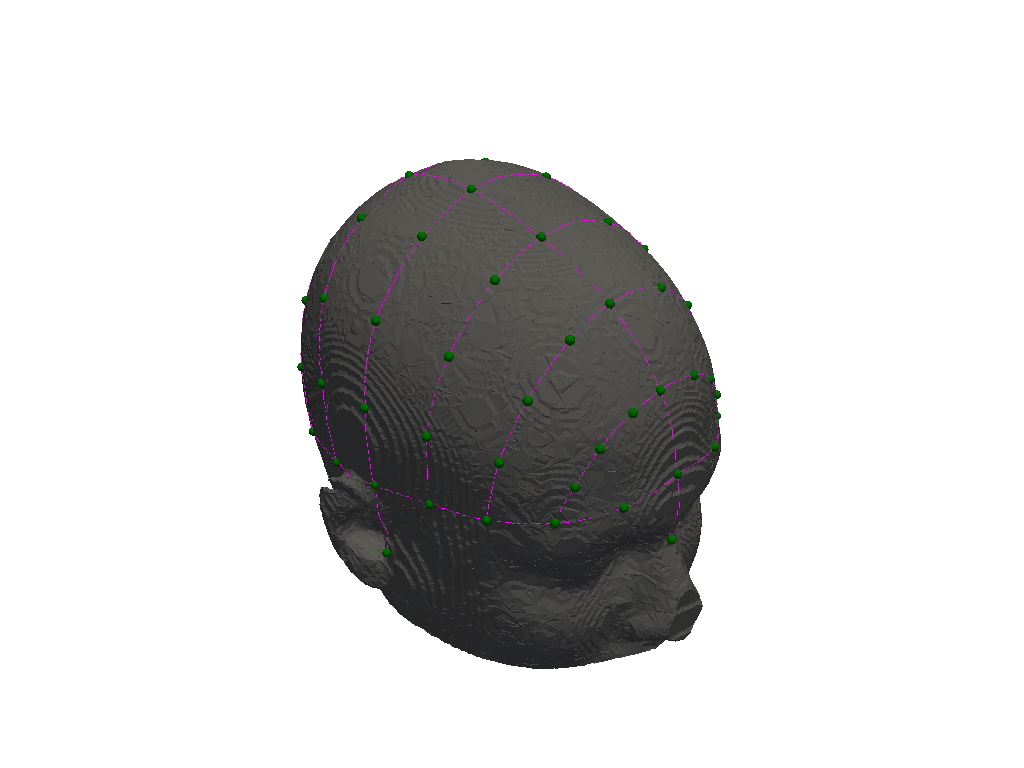

In [5]:
# Build the 10-10 system landmarks from the fiducials and the scalp using cedalions LandmarksBuilder1010
scalp_surface = colin.scalp

# Align fiducials to head coordinate system
fiducials_ras = cio.read_mrk_json(os.path.join(SEG_DATADIR, landmarks_file), crs="aligned")
fiducials_ijk = fiducials_ras.points.apply_transform(np.linalg.pinv(t_ijk2ras))
# Compute landmarks by EEG's 1010 system rules
lmbuilder = cgeolm.LandmarksBuilder1010(scalp_surface, fiducials_ijk)
all_landmarks = lmbuilder.build()
lmbuilder.plot()

## Load NinjaCap data

In [6]:
ninjacap_optodes, ninjacap_landmarks, meas_list = cedalion.datasets.get_ninja_cap_probe() 

In [7]:
# Handpick or load handpicked fiducials from file
fiducials_ras = cio.read_mrk_json(os.path.join(SEG_DATADIR, landmarks_file), crs="aligned")

## Construct transform from matching landmarks

In [8]:
# Individial landmarks
individual_ref_pos = np.array(all_landmarks)  
individual_ref_labels = [lab.item() for lab in all_landmarks.label] 

# Load ninja cap data
ninjacap_optodes, ninjacap_landmarks, meas_list = cedalion.datasets.get_ninja_cap_probe() 
ninja_ref_pos = list(np.array(ninjacap_landmarks.values))
ninja_ref_labels = list(np.array(ninjacap_landmarks.label))

# Construct transform from intersection
intersection = list(set(ninja_ref_labels) & set(individual_ref_labels)) 
individual_ref_pos = [individual_ref_pos[individual_ref_labels.index(intsct)] for intsct in intersection]
ninja_ref_pos = [ninja_ref_pos[ninja_ref_labels.index(intsct)] for intsct in intersection]
print("%d Landmarks used for co-registration:\n" % len(intersection), intersection)

73 Landmarks used for co-registration:
 ['C6', 'CP1', 'P8', 'P7', 'C2', 'LPA', 'F2', 'AF5', 'FCz', 'TP8', 'AF6', 'Fpz', 'C3', 'PO7', 'P5', 'FC2', 'Pz', 'TP7', 'CPz', 'F1', 'P4', 'P6', 'PO3', 'PO1', 'Fp2', 'AF3', 'CP2', 'PO6', 'FT8', 'C1', 'Cz', 'T7', 'F7', 'AF2', 'Fz', 'F6', 'C5', 'Fp1', 'FC6', 'Iz', 'AF1', 'PO5', 'FC3', 'O1', 'O2', 'F3', 'AFz', 'FC1', 'CP6', 'AF7', 'FC4', 'AF8', 'P2', 'FT7', 'F5', 'AF4', 'C4', 'FC5', 'PO8', 'P3', 'Nz', 'CP3', 'CP5', 'PO2', 'Oz', 'PO4', 'T8', 'F4', 'POz', 'CP4', 'P1', 'F8', 'RPA']


/usr/local/lib/python3.10/site-packages/xarray/core/variable.py:306: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


In [ ]:
# This is not working: register_trans_rot_isoscale throws some strange error about input datatypes I havn't solved yet
"""
# Individial landmarks
individual_ref_pos = all_landmarks
individual_ref_labels = [lab.item() for lab in all_landmarks.label] 

# Load ninja cap data
ninjacap_optodes, ninjacap_landmarks, meas_list = cedalion.datasets.get_ninja_cap_probe() 
ninja_ref_pos = ninjacap_landmarks
ninja_ref_labels = list(np.array(ninjacap_landmarks.label))

# Construct transform from intersection
intersection = list(set(ninja_ref_labels) & set(individual_ref_labels))
print("%d Landmarks used for co-registration:\n" % len(intersection), intersection)

individual_ref_pos = individual_ref_pos.sel(label=intersection)
ninja_ref_pos = ninja_ref_pos.sel(label=intersection)


T = cgeoreg.register_trans_rot_isoscale(ninja_ref_pos, ninja_ref_pos)
"""

In [9]:
# Alternative, non-cedalion, implementation from atlasviewer
def gen_xform_from_pts(p1, p2):
    """
    given two sets of points, p1 and p2 in n dimensions,
    find the n-dims affine transformation matrix t, from p1 to p2.

    Source: https://github.com/bunpc/atlasviewer/blob/71fc98ec8ca54783378310304113e825bbcd476a/utils/gen_xform_from_pts.m#l4
    
    parameters:
    p1 : ndarray
        an array of shape (p, n) representing the first set of points.
    p2 : ndarray
        an array of shape (p, n) representing the second set of points.

    returns:
    t : ndarray
        the (n+1, n+1) affine transformation matrix.
    """
    p1, p2 = np.array(p1), np.array(p2)
    p = p1.shape[0]
    q = p2.shape[0]
    m = p1.shape[1]
    n = p2.shape[1]
    
    if p != q:
        raise valueerror('number of points for p1 and p2 must be the same')
    
    if m != n:
        raise valueerror('number of dimensions for p1 and p2 must be the same')
    
    if p < n:
        raise valueerror(f'cannot solve transformation with fewer anchor points ({p}) than dimensions ({n}).')
    
    t = np.eye(n + 1)
    a = np.hstack((p1, np.ones((p, 1))))
    
    for ii in range(n):
        x = np.linalg.pinv(a) @ p2[:, ii]
        t[ii, :] = x
        
    return t


T = gen_xform_from_pts(ninja_ref_pos, individual_ref_pos); # get affine  

## Apply transform and snap optodes

In [10]:
# Apply transform
ninja_aligned = ninjacap_optodes.points.apply_transform(T)
# Snap to surface
ninja_snapped_aligned = colin.scalp.snap(ninja_aligned)
# Plot
cp.plot3d(None, scalp_surface.mesh, ninja_snapped_aligned, None)

Widget(value='<iframe src="http://localhost:53398/index.html?ui=P_0x14f858640_1&reconnect=auto" class="pyvista…

In [11]:
# Construct forward model
fwm = cedalion.imagereco.forward_model.ForwardModel(colin, ninja_snapped_aligned, meas_list)